# Importing Libraries

In [ ]:
import os
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils.np_utils import to_categorical
import keras

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


# Reading the dataset and arranging the emails and labels into lists.

In [ ]:
emails = []
labels = []
path = '/content/drive/My Drive/NLP Project/input/ham-and-spam-dataset/hamnspam/'

for label in ['ham','spam']:
    files = os.listdir(path + label)
    for file in files:
        f = open((path + label+'/' + file), 'r', encoding = 'latin-1')
        b = f.read()
        emails.append(b)
        labels.append(label)

# Creating a pandas dataset from the 2 lists for better convinence during data visualization and pre-processing

In [ ]:
df = pd.DataFrame({'emails': emails, 'labels': labels})
df

,emails,labels
0,Return-Path: tim.one@comcast.net\nDelivery-Dat...,ham
1,From spamassassin-talk-admin@lists.sourceforge...,ham
2,From spamassassin-talk-admin@lists.sourceforge...,ham
3,From spamassassin-commits-admin@lists.sourcefo...,ham
4,From easmith@beatrice.rutgers.edu Thu Sep 26 ...,ham
...,...,...
3047,From 2002biz2biz2513@Flashmail.com Mon Oct 7...,spam
3048,From biz2biz2446@Flashmail.com Mon Oct 7 22:...,spam
3049,From cna@insiq.us Tue Oct 8 00:10:39 2002\nR...,spam
3050,From OWNER-NOLIST-SGODAILY*JM**NETNOTEINC*-COM...,spam


# Visualizing data distribution.

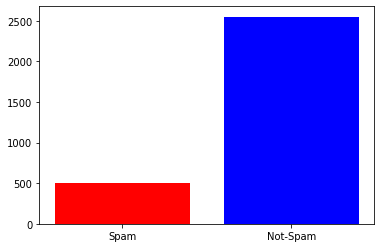

In [ ]:
plt.bar('Spam', len(os.listdir('/content/drive/My Drive/NLP Project/input/ham-and-spam-dataset/hamnspam/spam/')), color='r')
plt.bar('Not-Spam',len(os.listdir('/content/drive/My Drive/NLP Project/input/ham-and-spam-dataset/hamnspam/ham/')), color='b')
plt.show()

# Visualizing most commonly used words

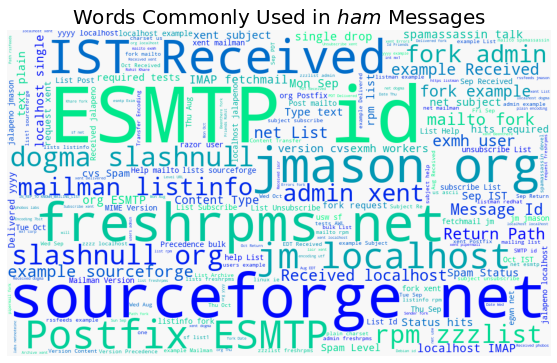

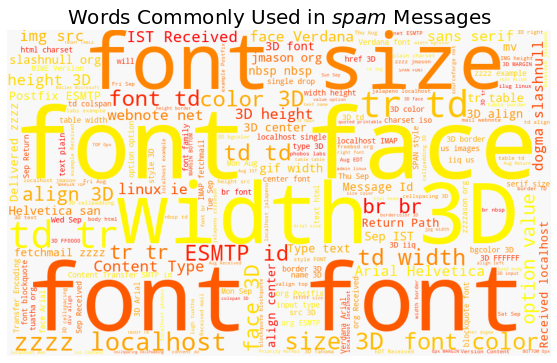

In [ ]:
for label, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = df.query("labels == @label")["emails"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

# Visualizing the length disstribution of the content in the emails.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'email length distribution')

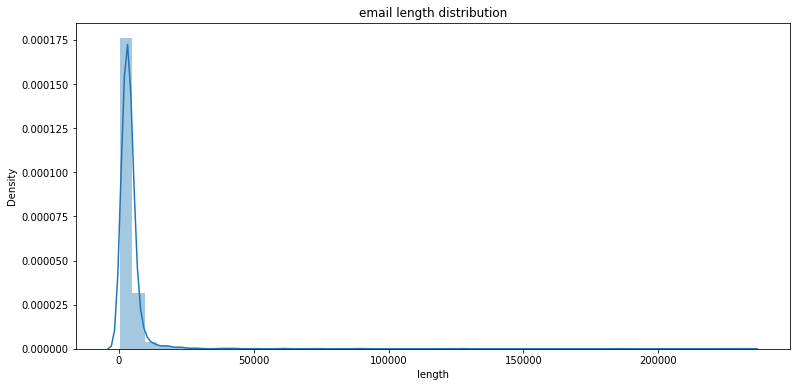

In [ ]:
df['length'] = df['emails'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['length']).set_title('email length distribution')

In [ ]:
df['length'].describe()

count      3052.000000
mean       4149.719528
std        7278.653344
min         368.000000
25%        2013.500000
50%        3358.000000
75%        4497.250000
max      232337.000000
Name: length, dtype: float64

# removing from the 95% percentile onwards to better understanding of the histogram:

In [ ]:
quantile_95 = df['length'].quantile(0.95)
df_95 = df[df['length'] < quantile_95]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


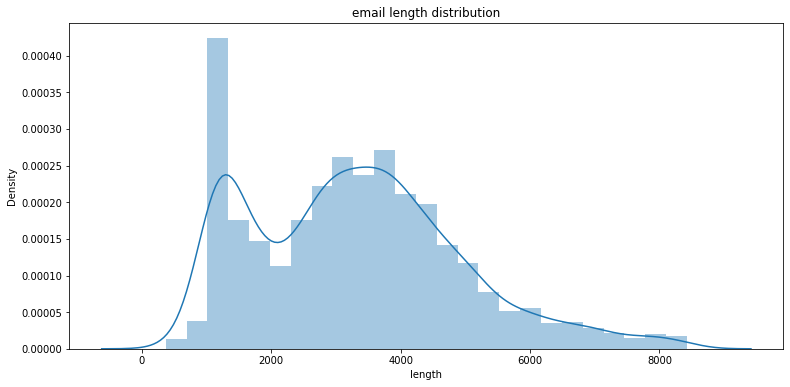

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['length']).set_title('email length distribution');

# Visualizing using boxplot

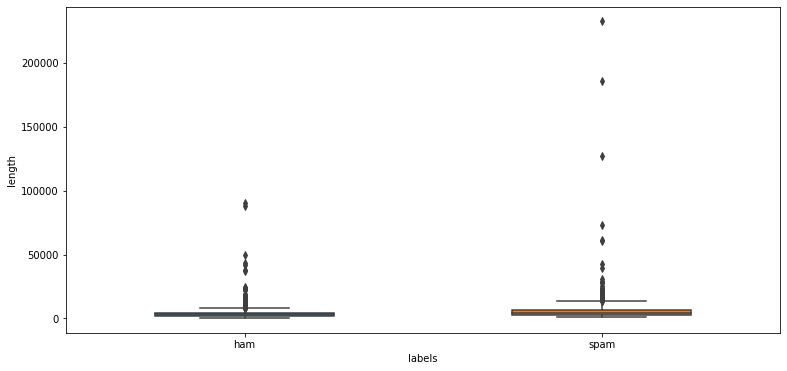

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='labels', y='length', width=.5);

# Visualizing after removing from the 95% percentile onwards to better understanding of the boxplot:

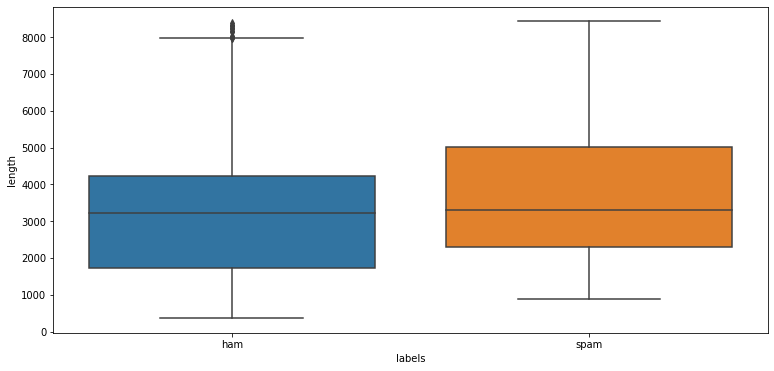

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='labels', y='length');

# Checking for missing data

In [ ]:
print(df.isnull().sum())

emails    0
labels    0
length    0
dtype: int64


#### there is no missing data

# Converting the data into lower case.

In [ ]:
df['emails'] = df['emails'].apply(lambda x:x.lower())

# removing punctuations

In [ ]:
punctuation_signs = list("?:!.,;")
df['emails'] = df['emails']

for punct_sign in punctuation_signs:   
    df['emails'] = df['emails'].str.replace(punct_sign, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """


# removing words with small lengths

In [ ]:
for i in range(len(df)):
    long_words=[]
    for j in df['emails'][i].split():
        if len(j)>=3:                  
            long_words.append(j)
    df['emails'][i]=" ".join(long_words)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Removing '\n' and '\t'.

In [ ]:
df['emails'] = df['emails'].apply(lambda x: x.replace('\n', ' '))
df['emails'] = df['emails'].apply(lambda x: x.replace('\t', ' '))

# Removing extra spaces

In [ ]:
df['emails'] = df['emails'].str.replace("    ", " ")

# Removing quoting text

In [ ]:
df['emails'] = df['emails'].str.replace('"', '')

# removing progressive pronouns

In [ ]:
df['emails'] = df['emails'].str.replace("'s", "")

# Lemmatization

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
nrows = len(df)
lemmatized_text_list = []
for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['emails']
    text_words = str(text).split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [ ]:
df['emails'] = lemmatized_text_list

# Removing Stop-words

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = list(stopwords.words('english'))

In [ ]:
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['emails'] = df['emails'].str.replace(regex_stopword, '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


# Encoding labels by converting 'ham' to 0 and 'spam' to 1.

In [ ]:
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])

# Using Bag of Words approach for final data Preparation.

In [ ]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(df['emails']).toarray()
y = df['labels']

# Splitting the Data using Stratified split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Using MultiNomial Naive Bayes as the Model and evaluating it using confusion matrix

accuracy is:  0.9770742358078602


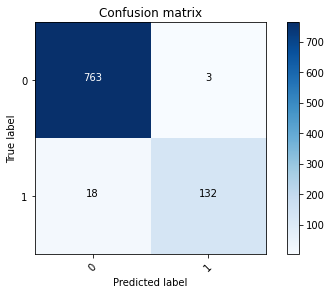

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using SVC as the Model and evaluating it using confusion matrix

accuracy is:  0.9836244541484717


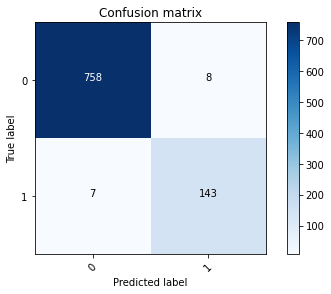

In [ ]:
clf = SVC(kernel='rbf', probability=True)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using KNeighbors Classifier as the Model and evaluating it using confusion matrix

accuracy is:  0.9836244541484717


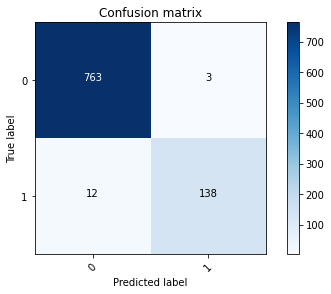

In [ ]:
clf = KNeighborsClassifier(n_neighbors=7)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using Random Forest Classifier as the Model and evaluating it using confusion matrix

accuracy is:  0.9912663755458515


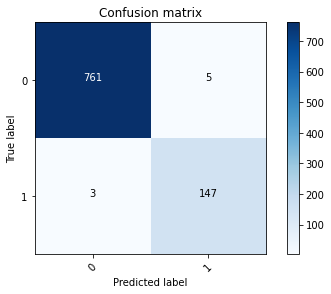

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using Decision tree as the Model and evaluating it using confusion matrix

accuracy is:  0.9978165938864629


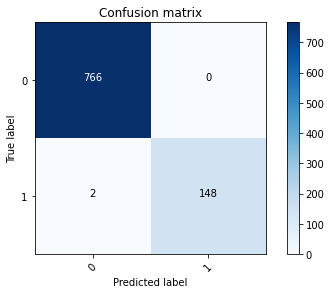

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using AdaBoost Classifier as the Model and evaluating it using confusion matrix

accuracy is:  1.0


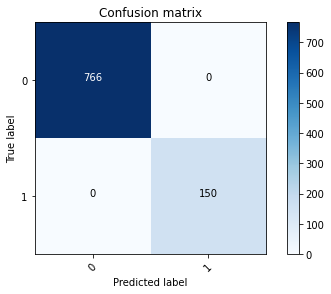

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Changing labels to categorical data

In [ ]:
y_train=to_categorical(y_train, num_classes = 2, dtype='float32')
y_test=to_categorical(y_test, num_classes = 2, dtype='float32')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model

# Creating an RNN Model and visualizing it

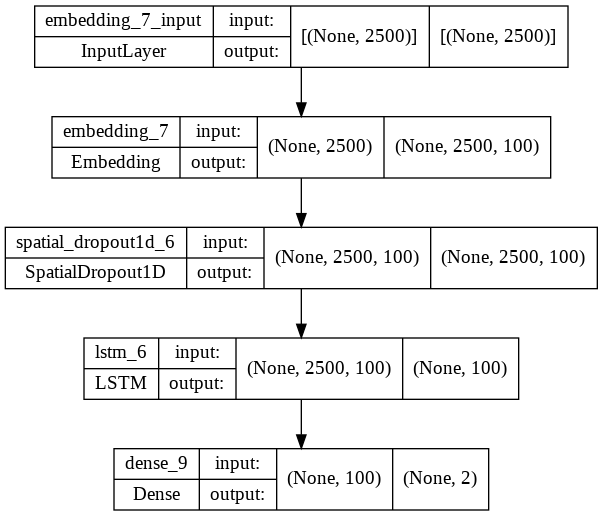

In [ ]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

keras.utils.plot_model(model, show_shapes=True)


# Training the model

In [ ]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
34/34 [==============================] - 194s 5s/step - loss: 0.5649 - accuracy: 0.7695 - val_loss: 0.4328 - val_accuracy: 0.8362
Epoch 2/10
34/34 [==============================] - 179s 5s/step - loss: 0.4307 - accuracy: 0.8305 - val_loss: 0.3501 - val_accuracy: 0.8362
Epoch 3/10
34/34 [==============================] - 188s 6s/step - loss: 0.2969 - accuracy: 0.8562 - val_loss: 0.2129 - val_accuracy: 0.9148
Epoch 4/10
34/34 [==============================] - 202s 6s/step - loss: 0.2163 - accuracy: 0.9017 - val_loss: 0.1832 - val_accuracy: 0.9279
Epoch 5/10
34/34 [==============================] - 207s 6s/step - loss: 0.1961 - accuracy: 0.9049 - val_loss: 0.1653 - val_accuracy: 0.9279
Epoch 6/10
34/34 [==============================] - 196s 6s/step - loss: 0.1583 - accuracy: 0.9272 - val_loss: 0.1488 - val_accuracy: 0.9378
Epoch 7/10
34/34 [==============================] - 194s 6s/step - loss: 0.1474 - accuracy: 0.9335 - val_loss: 0.1382 - val_accuracy: 0.9476
Epoch 8/10
34

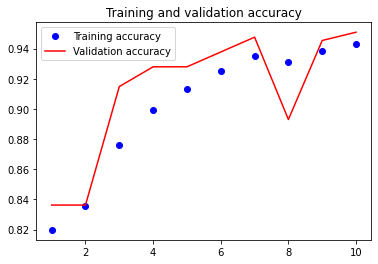

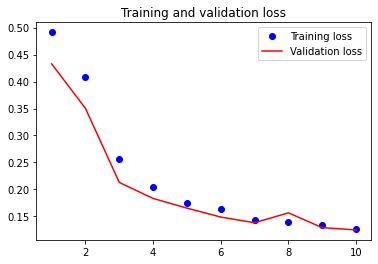

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**CNN Model**

In [ ]:
def plot_model(result):
    acc = result.history['acc']
    val_acc = result.history['val_acc']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    x = range(1, len(acc)+1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1,2,1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label= 'Validation acc')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='validation loss')
    plt.legend()
    
    plot_model(result)

In [ ]:
from keras.layers import Conv1D, MaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Dense, Embedding, GRU, LSTM, Dropout, Bidirectional

n_epochs = 10
model3 = Sequential()
model3.add(Embedding(input_dim=232337, output_dim=100, input_length=X_train.shape[1]))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(MaxPool1D(3))
model3.add(Dropout(0.2))
model3.add(Conv1D(128, 3, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.summary()
model3.add(Dense(1, activation='sigmoid'))


model3.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
result3 = model3.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, verbose=1)

eval_ = model3.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy



Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 2500, 100)         23233700  
                                                                 
 conv1d_6 (Conv1D)           (None, 2498, 128)         38528     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 832, 128)         0         
 1D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 832, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 830, 128)          49280     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                    

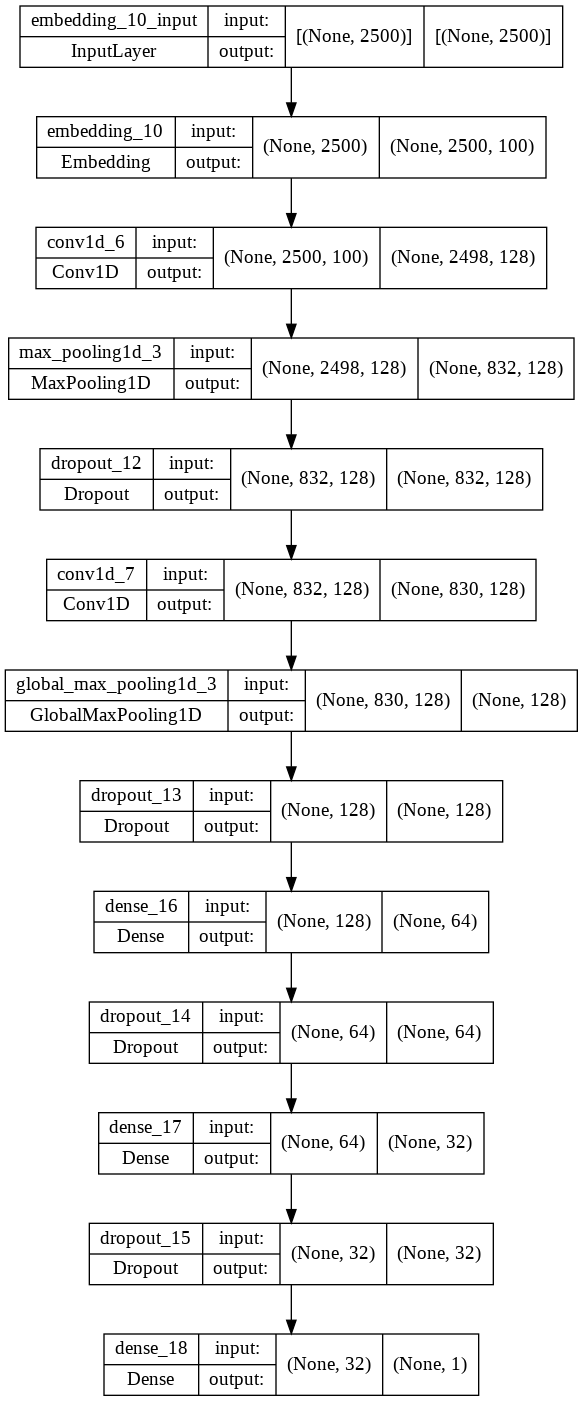

In [ ]:
keras.utils.plot_model(model3, show_shapes=True)


In [ ]:
print(eval_[0], eval_[1]) # loss / accuracy


0.19885984063148499 0.9203056693077087


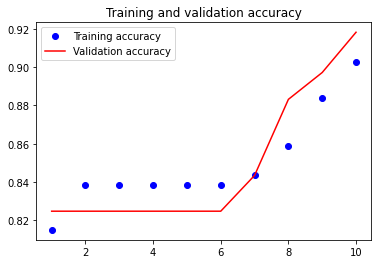

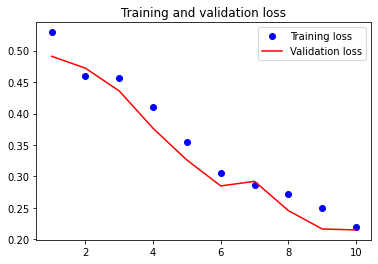

In [ ]:
acc = result3.history['accuracy']
val_acc = result3.history['val_accuracy']
loss = result3.history['loss']
val_loss = result3.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**GRU Model**

In [ ]:
model1 = Sequential()
model1.add(Embedding(input_dim=232337, output_dim=100, input_length=X_train.shape[1]))
model1.add(Dropout(0.8))
model1.add(GRU(140, return_sequences=False))
model1.add(Dropout(0.86))
model1.add(Dense(1, activation='sigmoid', name='Classification'))
model1.summary()

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
results1 = model1.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

eval_ = model1.evaluate(X_test, y_test)
print(eval_[0], eval_[1]) # loss / accuracy



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 2500, 100)         23233700  
                                                                 
 dropout_16 (Dropout)        (None, 2500, 100)         0         
                                                                 
 gru (GRU)                   (None, 140)               101640    
                                                                 
 dropout_17 (Dropout)        (None, 140)               0         
                                                                 
 Classification (Dense)      (None, 1)                 141       
                                                                 
Total params: 23,335,481
Trainable params: 23,335,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
27/27 [=======================

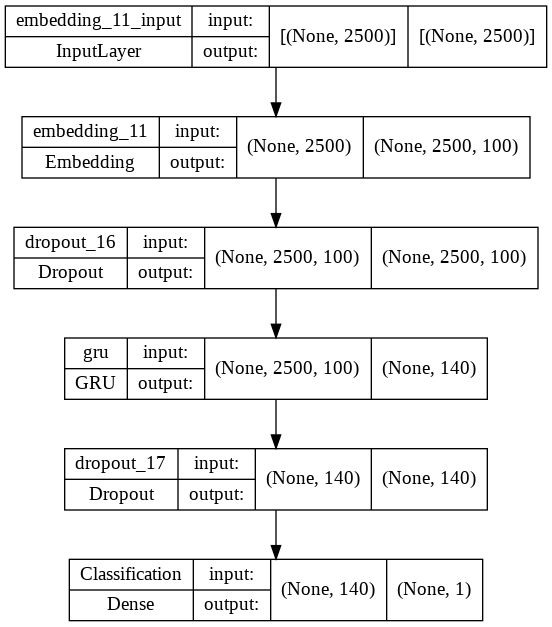

In [ ]:
keras.utils.plot_model(model1, show_shapes=True)


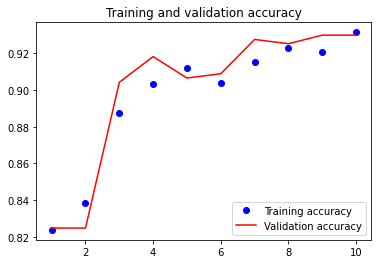

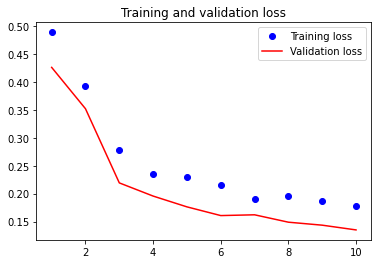

In [ ]:
acc = results1.history['accuracy']
val_acc = results1.history['val_accuracy']
loss = results1.history['loss']
val_loss = results1.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**BERT Model**

In [ ]:
pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 462 kB 51.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
X = df['emails']
y = df['labels']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['emails'],df['labels'])

In [ ]:
df

,emails,labels,length
0,return-path timone@comcastnet delivery-date fr...,0,1553
1,spamassassin-talk-admin@listssourceforgenet t...,0,3597
2,spamassassin-talk-admin@listssourceforgenet t...,0,4379
3,spamassassin-commits-admin@listssourceforgene...,0,15943
4,easmith@beatricerutgersedu thu sep 162949 200...,0,3096
...,...,...,...
3047,2002biz2biz2513@flashmailcom mon oct 224203 2...,1,5023
3048,biz2biz2446@flashmailcom mon oct 224204 2002 ...,1,5007
3049,cna@insiqus tue oct 001039 2002 return-path <...,1,17626
3050,owner-nolist-sgodaily*jm**netnoteinc*-com@smt...,1,12049


In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
72/72 [==============================] - 1080s 15s/step - loss: 0.4390 - accuracy: 0.8239 - precision: 0.1875 - recall: 0.0076
Epoch 2/10
72/72 [==============================] - 1069s 15s/step - loss: 0.4370 - accuracy: 0.8213 - precision: 0.2895 - recall: 0.0280
Epoch 3/10
72/72 [==============================] - 1066s 15s/step - loss: 0.4221 - accuracy: 0.8218 - precision: 0.2973 - recall: 0.0280
Epoch 4/10
72/72 [==============================] - 1062s 15s/step - loss: 0.4069 - accuracy: 0.8231 - precision: 0.3500 - recall: 0.0356
Epoch 5/10
72/72 [==============================] - 1065s 15s/step - loss: 0.4019 - accuracy: 0.8204 - precision: 0.2857 - recall: 0.0305
Epoch 6/10
72/72 [==============================] - 1061s 15s/step - loss: 0.3914 - accuracy: 0.8244 - precision: 0.3846 - recall: 0.0382
Epoch 7/10
70/72 [============================>.] - ETA: 29s - loss: 0.3857 - accuracy: 0.8263 - precision: 0.4667 - recall: 0.0544

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
sample_dataset = [
    'You have an offer, the company will give you 50% off in every item purchased.',
    'Hey Bravin, dont be late for the meeting tomorrow',
    "See you monday, we have alot to talk about the future of this company ."
    'You can win alot of money, register in the link below',
    'You have an iphone 10, spin the image below to claim your prize and it willl be delivered in your door step',
]
model.predict(sample_dataset)

array([[0.74588776],
       [0.49036163],
       [0.6283092 ],
       [0.8709258 ],
       [0.8911692 ]], dtype=float32)

Predicted value below 5 are considered as ham and above 5 are considered as spam

Bert Hugging face transformer

In [ ]:
import email
from bs4 import BeautifulSoup
path = '/content/drive/My Drive/NLP Project/input/ham-and-spam-dataset/hamnspam/'

topics = []
contents = []
labels = []
num_mails = []
content_types = []

count = 0
error = 0
wrongContentType = 0
for label in ['ham', 'spam']:
    filenames = os.listdir(path + label + '/')
    for filename in filenames:
        count +=1
        labels.append(1 if label == 'spam' else 0)
        with open(os.path.join(path + label + '/', filename), 'rb') as file:
            email_file = email.parser.BytesParser(policy=email.policy.default).parse(file)
            payload = email_file.get_payload()
            num_mails.append(1 if not isinstance(payload, list) else len(payload))
            try:
                if email_file.get_content_type() == 'text/plain':
                    contents.append(email_file.get_content())
                elif email_file.get_content_type() == 'text/html':
                    contents.append(BeautifulSoup(email_file.get_content()).body.text)
                else:
                    wrongContentType += 1
                    contents.append('')
                topics.append(email_file['Subject'])
                content_types.append(email_file.get_content_type())
            except LookupError:
                error +=1
                topics.append(None)
                contents.append('')
                content_types.append('')
                pass
        
inputDF = pd.DataFrame({'topic': topics, 'content': contents, 'label': labels, 'num_mails_in_flow': num_mails, 'content_type': content_types})
print('# processed message: %d', count)
print('# failed-parsed message: %d', error)
print('# non-text message: %d', wrongContentType)

# processed message: %d 3052
# failed-parsed message: %d 3
# non-text message: %d 196


In [ ]:
inputDF.describe()

,label,num_mails_in_flow
count,3052.000000,3052.000000
mean,0.164155,1.050131
std,0.370477,0.224178
min,0.000000,1.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,3.000000


In [ ]:
inputDF.loc[inputDF['content_type'] == 'text/html'].head(5)


,topic,content,label,num_mails_in_flow,content_type
2558,Conference calls/best quality/$.18 per minute!,\n\n\n\n\n\nConferencing Made Easy\nOnly 18 Ce...,1,1,text/html
2560,Let me know what you think!32482,\n\n__________________________________________...,1,1,text/html
2562,Mothers you want to fuck,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,1,1,text/html
2569,Incredible Pictures!!!!!!!!,\nDo you like Sexy Animals doing the wild thin...,1,1,text/html
2572,- Custom Websites for $399 Complete! (1709D@5),"\n\n\n\n\n\nBeautiful, 100% Custom \n Web...",1,1,text/html


In [ ]:
# It seems that an email of 'text/html' is likely to be a spam.


inputDF.loc[inputDF['content_type'].str.startswith('multipart')].head(5)


,topic,content,label,num_mails_in_flow,content_type
9,Re: [Razor-users] Razor with sendmail,,0,2,multipart/signed
17,Re: [SAtalk] Getting yourself removed from spa...,,0,2,multipart/signed
49,Re: [SAtalk] O.T. Habeus -- Why?,,0,2,multipart/signed
61,Re: [SAtalk] Still confused about spamd/c,,0,2,multipart/signed
95,[SAtalk] spamc and DCC,,0,2,multipart/alternative


In [ ]:
inputDF['topic_content'] = inputDF.topic.astype('U') + " " + inputDF.content
inputDF.topic_content

0       [Spambayes] test sets? [Skip Montanaro]\n> Any...
1       [SAtalk] "Broken Pipe" on initial test Hi\n\nI...
2       Re: [SAtalk] O.T. Habeus -- Why? \nOn Wednesda...
3       [SACVS] CVS: spamassassin configure,1.1.2.1,1....
4       Re: GA Development (was Re: [SAdev] [Bug 1030]...
                              ...                        
3047    FWD:Direct marketing is working               ...
3048    See your Company sales sky rocket.            ...
3049                               Hit the Road with CNA 
3050    MAKE MONEY GIVING AWAY FREE STUFF! \n\n\n\n\n\...
3051    Faeries UNCOMMON EXOTIC PLEASURE BOTANICALS!\n...
Name: topic_content, Length: 3052, dtype: object

In [ ]:
y = inputDF.label
X = inputDF.topic_content
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y, shuffle=True)
X_train.shape, X_test.shape

((2044,), (1008,))

In [ ]:
def get_strategy():
    try:
        tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu_cluster_resolver.cluster_spec().as_dict()['worker'])
        tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)
        strategy = tf.distribute.experimental.TPUStrategy(tpu_cluster_resolver)
    except ValueError as e:
        print(e)
        print('No TPU detected')
        tpu = None
        strategy = tf.distribute.get_strategy()
    return strategy

strategy = get_strategy()

Running on TPU  ['10.76.158.202:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.76.158.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.158.202:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
!pip install -q transformers

# Loading the BERT Classifier and Tokenizer along with Input module
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputFeatures

     |████████████████████████████████| 4.0 MB 4.8 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
     |████████████████████████████████| 6.6 MB 39.1 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
features_train = tokenizer.batch_encode_plus(X_train, padding='max_length', truncation=True,
                                             max_length=512,return_tensors='tf',add_special_tokens=True,
                                             return_token_type_ids=True, return_attention_mask=True)

features_test = tokenizer.batch_encode_plus(X_test, padding='max_length', truncation=True,
                                            max_length=512,return_tensors='tf',add_special_tokens=True,
                                            return_token_type_ids=True, return_attention_mask=True)

In [ ]:
tf.keras.backend.clear_session()

with strategy.scope():
    bertModel = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
    bertModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
#     bertModel.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    bertModel.summary()

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
bertModel.fit(x=features_train.data, y=y_train, epochs=10, batch_size=128, verbose=1)

Epoch 1/10
16/16 [==============================] - 111s 457ms/step - loss: 0.4524 - accuracy: 0.8019
Epoch 2/10
16/16 [==============================] - 7s 457ms/step - loss: 0.2810 - accuracy: 0.8488
Epoch 3/10
16/16 [==============================] - 7s 457ms/step - loss: 0.1563 - accuracy: 0.9095
Epoch 4/10
16/16 [==============================] - 7s 457ms/step - loss: 0.0524 - accuracy: 0.9917
Epoch 5/10
16/16 [==============================] - 7s 457ms/step - loss: 0.0193 - accuracy: 0.9956
Epoch 6/10
16/16 [==============================] - 7s 458ms/step - loss: 0.0148 - accuracy: 0.9961
Epoch 7/10
16/16 [==============================] - 7s 458ms/step - loss: 0.0114 - accuracy: 0.9971
Epoch 8/10
16/16 [==============================] - 7s 458ms/step - loss: 0.0066 - accuracy: 0.9985
Epoch 9/10
16/16 [==============================] - 7s 460ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 10/10
16/16 [==============================] - 7s 457ms/step - loss: 0.0014 - accuracy: 1.00

In [ ]:
bert_outputs = bertModel(features_test.data)
bert_outputs

TFSequenceClassifierOutput([('logits',
                             <tf.Tensor: shape=(1008, 2), dtype=float32, numpy=
                             array([[ 3.7481406, -4.186238 ],
                                    [-3.3077157,  3.6597097],
                                    [ 3.56732  , -3.6917834],
                                    ...,
                                    [ 2.4258235, -2.7066622],
                                    [ 3.7398157, -4.16072  ],
                                    [-3.4023583,  3.6043613]], dtype=float32)>)])

In [ ]:
softmax_outputs = tf.nn.softmax(bert_outputs[0], axis=-1)
softmax_outputs

<tf.Tensor: shape=(1008, 2), dtype=float32, numpy=
array([[9.9964190e-01, 3.5808620e-04],
       [9.4118866e-04, 9.9905878e-01],
       [9.9929678e-01, 7.0324360e-04],
       ...,
       [9.9413270e-01, 5.8672461e-03],
       [9.9962962e-01, 3.7040780e-04],
       [9.0495538e-04, 9.9909508e-01]], dtype=float32)>

accuracy is:  0.9930555555555556


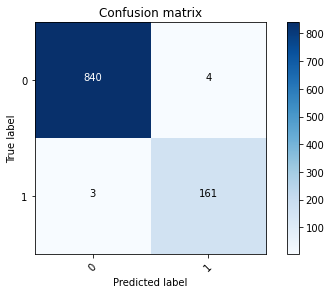

In [ ]:
accuracy = accuracy_score(y_pred, np.array(y_test))
print("accuracy is: ",accuracy)
y_pred = np.argmax(softmax_outputs.numpy(), axis=1)
# reportTest(y_pred, np.array(y_test))
CM = confusion_matrix(y_pred, np.array(y_test))
plot_confusion_matrix(CM, classes = range(2))